In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("dataset_new.csv", header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.0065,0.0130,0.0195,0.0260,0.0325,0.0390,0.0455,0.0520,0.0585,0.0650,...,0.0316,0.0368,0.0312,0.0000,0.0316,0.0364,0.0304,0.0604,0.9960,1
1,0.0263,0.0526,0.0789,0.1052,0.1316,0.1579,0.1842,0.2105,0.2368,0.2631,...,0.0316,0.0368,0.0312,0.0000,0.0316,0.0364,0.0304,0.0604,0.9960,1
2,0.0176,0.0352,0.0528,0.0704,0.0881,0.1057,0.1233,0.1409,0.1585,0.1761,...,0.0316,0.0368,0.0312,0.0312,0.0316,0.0299,0.0304,0.0604,0.9957,1
3,0.0222,0.0444,0.0666,0.0888,0.1110,0.1332,0.1554,0.1776,0.1998,0.2220,...,0.0316,0.0307,0.0312,0.0000,0.0360,0.0364,0.0304,0.0604,0.9900,1
4,0.0189,0.0379,0.0568,0.0758,0.0947,0.1137,0.1326,0.1516,0.1705,0.1895,...,0.0316,0.0368,0.0312,0.0000,0.0316,0.0364,0.0304,0.0604,0.9862,1


In [ ]:
df.shape

(20000, 55)

In [ ]:
import tensorflow as tf
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [ ]:
def normalize_data(data):
    data = np.transpose(data)
    scalar = MinMaxScaler((0,1))
    scalar.fit(data)
    data = scalar.transform(data)
    output = np.transpose(data)
    return output

In [ ]:
classes = ['Low_traffic', 'High_traffic']
num_classes = len(classes)
in_dim = [2, 13]
X = df.iloc[:,0:26].to_numpy()
Y = df.iloc[:,26:52].to_numpy()
IPI = df.iloc[:,52].to_numpy()
col = df.iloc[:,53].to_numpy()
Label = df.iloc[:,54].to_numpy()
Label_cat = tf.keras.utils.to_categorical(Label,num_classes)

In [ ]:
Label

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
Y[0]

array([0.    , 0.    , 0.4992, 0.002 , 0.    , 0.0012, 0.0368, 0.0404,
       0.    , 0.0312, 0.0284, 0.    , 0.0296, 0.0368, 0.0344, 0.    ,
       0.0312, 0.0304, 0.    , 0.0316, 0.0368, 0.0312, 0.    , 0.0316,
       0.0364, 0.0304])

In [ ]:
IPI[0]

0.0604

(array([4.86889e+05, 2.37100e+04, 5.19300e+03, 2.31100e+03, 1.10400e+03,
        4.63000e+02, 8.00000e+01, 7.00000e+01, 8.70000e+01, 9.30000e+01]),
 array([2.300000e-03, 4.910370e+00, 9.818440e+00, 1.472651e+01,
        1.963458e+01, 2.454265e+01, 2.945072e+01, 3.435879e+01,
        3.926686e+01, 4.417493e+01, 4.908300e+01]),
 <BarContainer object of 10 artists>)

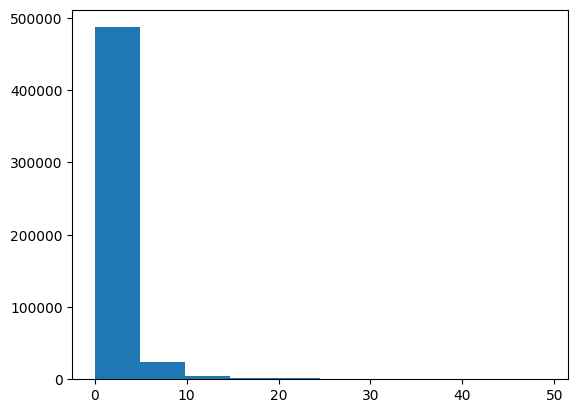

In [ ]:
plt.hist(np.array(X).flatten())

In [ ]:
np.random.seed(seed=int(time.time()))
n_examples = X.shape[0]
n_train = n_examples * 0.7
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test = X[test_idx]
Y_train = Y[train_idx]
Y_test = Y[test_idx]
IPI_train = IPI[train_idx]
IPI_test = IPI[test_idx]
col_train = col[train_idx]
col_test = col[test_idx]
Label_train = Label_cat[train_idx]
Label_test = Label_cat[test_idx]


In [ ]:
def get_model(X_shape, Y_shape, IPI_shape, col_shape, classes, verbose):
    dr = 0.30
    model_X = tf.keras.models.Sequential()
    model_X.add(layers.Reshape((X_shape, 1), input_shape=(X_shape, ) ))
    model_X.add(layers.Conv1D(32, 3, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_X.add(layers.BatchNormalization())

    model_X.add(layers.Conv1D(16, 2, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_X.add(layers.Flatten())
    model_X.add(layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_X.add(layers.Dropout(dr))
    model_X.add(layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_X.add(layers.Dropout(dr))

    model_Y = tf.keras.models.Sequential()
    model_Y.add(layers.Reshape((Y_shape, 1), input_shape=(Y_shape, ) ))
    model_Y.add(layers.Conv1D(256, 3, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01) ))
    model_Y.add(layers.BatchNormalization())

    model_Y.add(layers.Conv1D(128, 2, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_Y.add(layers.Flatten())
    model_Y.add(layers.Dropout(dr))
    model_Y.add(layers.Dense(256, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01) ))
    model_Y.add(layers.Dropout(dr))
    model_Y.add(layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_Y.add(layers.Dropout(dr))

    model_IPI = tf.keras.models.Sequential()
    model_IPI.add(layers.Dense(IPI_shape, activation=tf.nn.relu, input_shape=(IPI_shape, )))

    model_IPI.add(layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_IPI.add(layers.Dropout(dr))
    model_IPI.add(layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_IPI.add(layers.Dropout(dr))

    model_col = tf.keras.models.Sequential()
    model_col.add(layers.Dense(col_shape, activation=tf.nn.relu, input_shape=(col_shape, )))

    model_col.add(layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_col.add(layers.Dropout(dr))
    model_col.add(layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)))
    model_col.add(layers.Dropout(dr))

    merged = tf.keras.layers.Concatenate(axis=1)([model_X.output, model_Y.output, model_IPI.output, model_col.output])
    merged = layers.Dense(256,activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(merged)
    merged = layers.Dropout(dr)(merged)
    merged = layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(merged)
    merged = layers.Dropout(dr)(merged)
    merged = layers.Dense(len(classes), activation=tf.nn.softmax, name='class_output')(merged)

    model = tf.keras.models.Model([model_X.input,model_Y.input, model_IPI.input, model_col.input], merged)

    if(verbose):
        from tensorflow.keras.utils import plot_model
        from IPython.display import Image
        plot_model(model, to_file='model.png', show_shapes=True)

    print("--Model created")
    return model


In [ ]:
model = get_model(X.shape[1], Y.shape[1], 1, 1, classes, verbose=1)

--Model created


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 reshape_1_input (InputLayer)   [(None, 26)]         0           []                               
                                                                                                  
 reshape_input (InputLayer)     [(None, 26)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 26, 1)        0           ['reshape_1_input[0][0]']        
                                                                                                  
 reshape (Reshape)              (None, 26, 1)        0           ['reshape_input[0][0]']          
                                                                                              

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss= 'categorical_crossentropy', metrics=['accuracy']  )

In [ ]:
savedir = 'model_LTE_WiFi_coexistance_histogram+IPI+col.h5'
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0, patience = 20, verbose = 0, mode = 'auto')
checkpoint = tf.keras.callbacks.ModelCheckpoint(savedir, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=0.00001, cooldown=0, min_lr=0.0001)
nb_epoch = 5000
batch_size = 16
history = model.fit(x = [X_train, Y_train, np.transpose(IPI_train), np.transpose(col_train)], y = Label_train ,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data = ([X_test, Y_test, np.transpose(IPI_test), np.transpose(col_test)], Label_test),
                    shuffle=True,
                    verbose=2,
                    callbacks = [early_stop, checkpoint, reduce_lr_callback] )


Epoch 1/5000

Epoch 1: loss improved from inf to 1.07186, saving model to model_LTE_WiFi_coexistance_histogram+IPI+col.h5
875/875 - 47s - loss: 1.0719 - accuracy: 0.9361 - val_loss: 0.2558 - val_accuracy: 0.9530 - lr: 0.0010 - 47s/epoch - 53ms/step
Epoch 2/5000

Epoch 2: loss improved from 1.07186 to 0.25574, saving model to model_LTE_WiFi_coexistance_histogram+IPI+col.h5
875/875 - 27s - loss: 0.2557 - accuracy: 0.9512 - val_loss: 0.2154 - val_accuracy: 0.9632 - lr: 0.0010 - 27s/epoch - 30ms/step
Epoch 3/5000

Epoch 3: loss improved from 0.25574 to 0.22894, saving model to model_LTE_WiFi_coexistance_histogram+IPI+col.h5
875/875 - 27s - loss: 0.2289 - accuracy: 0.9544 - val_loss: 0.2251 - val_accuracy: 0.9528 - lr: 0.0010 - 27s/epoch - 30ms/step
Epoch 4/5000

Epoch 4: loss improved from 0.22894 to 0.21807, saving model to model_LTE_WiFi_coexistance_histogram+IPI+col.h5
875/875 - 27s - loss: 0.2181 - accuracy: 0.9552 - val_loss: 0.1837 - val_accuracy: 0.9670 - lr: 0.0010 - 27s/epoch - 31

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


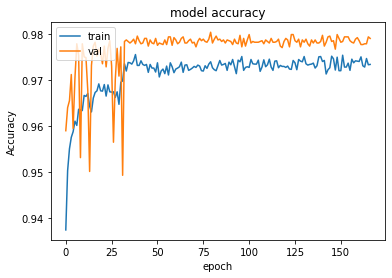

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

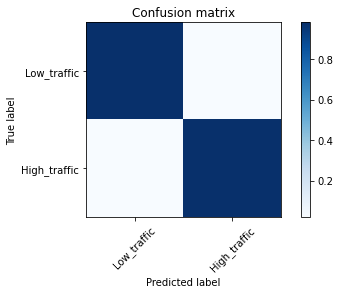

In [ ]:
X = [X_test, Y_test, np.transpose(IPI_test), np.transpose(col_test)]

test_Y_hat = model.predict(X, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm1 = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Label_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm1[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm1, labels=classes)


In [ ]:
print(confnorm1)

[[0.98081454 0.01918546]
 [0.0227798  0.9772202 ]]


In [ ]:
IPI.shape

(20000,)

In [ ]:
y_pred=model.predict([X_test, Y_test, np.transpose(IPI_test), np.transpose(col_test)])

NameError: ignored

In [ ]:
y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
Label_test = np.argmax(Label_test, axis=-1)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(Label_test, y_pred))

Accuracy: 0.979


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
batch_size = 512

In [ ]:
import pandas as pd
df = pd.read_csv("dataset_test.csv", header=None)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.0662,0.1324,0.1986,0.2648,0.3310,0.3972,0.4634,0.5296,0.5958,0.662,...,0.0008,0.0000,0.0000,0.0000,0.0008,0.0004,0.0776,0.2282,0.9463,0
1,0.0662,0.1324,0.1986,0.2648,0.3310,0.3972,0.4634,0.5296,0.5958,0.662,...,0.0004,0.0000,0.0004,0.0000,0.0008,0.0008,0.0792,0.2293,0.9524,0
2,0.2692,0.5384,0.8076,1.0768,1.3460,1.6152,1.8844,2.1536,2.4228,2.692,...,0.0000,0.0021,0.0010,0.0000,0.0052,0.0010,0.2884,1.5919,0.9828,0
3,0.0380,0.0760,0.1140,0.1520,0.1900,0.2280,0.2660,0.3040,0.3420,0.380,...,0.0000,0.0000,0.0000,0.0120,0.0176,0.0060,0.0056,0.1430,0.9826,0
4,0.0383,0.0766,0.1149,0.1532,0.1915,0.2298,0.2681,0.3064,0.3447,0.383,...,0.0000,0.0008,0.0000,0.0116,0.0180,0.0084,0.0032,0.1428,0.9810,0
5,0.0373,0.0746,0.1119,0.1492,0.1865,0.2238,0.2611,0.2984,0.3357,0.373,...,0.0004,0.0000,0.0000,0.0000,0.0168,0.0136,0.0092,0.1428,0.9810,0
6,0.0380,0.0760,0.1140,0.1520,0.1900,0.2280,0.2660,0.3040,0.3420,0.380,...,0.0000,0.0004,0.0004,0.0096,0.0168,0.0104,0.0048,0.1438,0.9873,0
7,0.0376,0.0752,0.1128,0.1504,0.1880,0.2256,0.2632,0.3008,0.3384,0.376,...,0.0008,0.0000,0.0000,0.0040,0.0204,0.0112,0.0064,0.1432,0.9841,0
8,0.0379,0.0758,0.1137,0.1516,0.1895,0.2274,0.2653,0.3032,0.3411,0.379,...,0.0008,0.0000,0.0000,0.0076,0.0168,0.0108,0.0048,0.1421,0.9778,0
9,0.0376,0.0752,0.1128,0.1504,0.1880,0.2256,0.2632,0.3008,0.3384,0.376,...,0.0004,0.0004,0.0000,0.0040,0.0196,0.0092,0.0076,0.1430,0.9826,0


In [ ]:
y_actual = df.iloc[:,54].to_numpy()

In [ ]:
y_actual

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0])

In [ ]:
X_test = df.iloc[:,0:26].to_numpy()
Y_test = df.iloc[:,26:52].to_numpy()
IPI = df.iloc[:,52].to_numpy()
col = df.iloc[:,53].to_numpy()

In [ ]:
Y_test.shape

(50, 26)

In [ ]:
X_test.shape

(50, 26)

In [ ]:
Y_test.shape

(50, 26)

In [ ]:
IPI.shape

(50,)

In [ ]:
y_pred=model.predict([X_test, Y_test, np.transpose(IPI), np.transpose(col)])

NameError: ignored

In [ ]:
y_pred

In [ ]:
y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_actual, y_pred))